---
---

# 0. Imports

---
---

In [1]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

# import tqdm for progress bar
from tqdm.auto import tqdm

# import PyTorch related libraries
import torch
from torch import nn

import torchvision 
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

# import helper functions tools
from helper_functions import load_cifar10
from helper_functions import decision_surface
from helper_functions import decision_surface_torch

# general settings
plt.style.use('ggplot')
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
np.set_printoptions(precision=2)

C:\Users\alireza\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\alireza\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\alireza\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


---
---


# 1. Definitions


---
---

The first section of the notebook contains the definitions of all tools used in the section two of the notebook.

## 1.1 implementing neural network architecture from scratch 

from now on, we are going to call all instances of `Dense_Layer` class as **independent models**.

### 1.1.1 Base Layer

In [2]:
# The parent class of all Layers
class Layer:
    def __init__(self):
        self.input = 0
        self.output = 0
    def forward(self):
        pass
    def backward(self):
        pass

### 1.1.2 Dense Layer

In [3]:
# Provides the ability to create a sequential network of arbitrary number of dense layers (fully connected).
class Dense_Layer(Layer):
    def __init__(self, input_size, output_size):
        np.random.seed(10)
        self.weights = np.random.randn(output_size, input_size) * 0.01
        self.bias = np.random.randn(output_size, 1) * 0.01
    
    def forward(self, Xs):
        self.input = Xs
        self.output = np.dot(self.weights, self.input) + self.bias
        return self.output
    
    def backward(self, chained_grad, learning_rate):
        weights_grad = np.dot(chained_grad, self.input.T)
        input_grads = np.dot(self.weights.T, chained_grad) 

        self.weights -= learning_rate * weights_grad / chained_grad.shape[1]
        self.bias -= learning_rate * chained_grad.sum(axis=1, keepdims=True) / chained_grad.shape[1]

        return input_grads

### 1.1.3 Activation Layer

In [4]:
# Implementing Activation part as a seperate layer is more intuitive and simplifies the coding  
class activation_layer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, Xs):
        self.input = Xs
        self.output = self.activation(self.input)
        return self.output

    def backward(self, chained_grad, learning_rate):
        input_grad = self.activation_prime(self.input) * chained_grad
        return input_grad

## 1.2 Different Activation Functions

After implementing the framework of activation layer as the activation_layer class, we need to define certain activation functions, both for forward and backward.
Here we implemented the four most famous activation functions:
- Sigmoid
- Tanh
- ReLU
- Leaky ReLU

In [5]:
# implement 'Sigmoid' activation function for both forward and backward path
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    sig = (1 / (1 + np.exp(-x)))
    return sig * (1 - sig)


# implement 'Tanh' activation function for both forward and backward path
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - tanh(x)**2


# implement 'ReLU' activation function for both forward and backward path
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    grads = np.zeros_like(x)
    grads[x > 0] = 1 
    return grads


# implement 'Leaky ReLU' activation function for both forward and backward path
def leaky_relu(x):
    return np.maximum(0.1*x, x)

def leaky_relu_prime(x):
    grads = np.full(x.shape, 0.1)
    grads[x > 0.1 * x] = 1
    return grads


## 1.3 Different Loss Functions

One of the elementary parts of each learning procedure is the **Loss function / Cost function**, there are many different 
cost functions for different purposes, here we are implementing three different loss functions. 
- Mean Squared Error (MSE)
- Cross Entropy
- Multiclass Hinge loss

As the loss function is the final computation applied on the network's input, the backpropagation strarts on it, so we need
to implement both the forward path, and the backward path for each loss function.

In [6]:
# different loss functions

# Mean Squared Error 
def mse(y_true, y_pred):
    return np.mean( (y_true - y_pred)**2 )

def mse_prime(y_true, y_pred):
    grads = 2 * (y_pred - y_true) / np.size(y_true)
    return np.array(grads)



# Cross Entropy vectorized implementation for both forward and backward pass
def cross_entropy(y_true, x):
    loss_of_samples = -np.log(np.exp(x[y_true, range(x.shape[1])]) / np.exp(x).sum(axis=0))
    return loss_of_samples.sum()

def cross_entropy_prime(y_true, x):
    exponents = np.exp(x)
    denoms = exponents.sum(axis=0)                                             
    grads =  exponents / denoms
    grads[y_true, range(x.shape[1])] -= 1    
    return grads



# Multiclass hinge vectorized implementation for both forward and backward pass
def multi_class_hinge(y_true, x, delta=1):
    losses = np.maximum(0, x - x[y_true, range(x.shape[1])] + delta)
    losses[y_true, range(losses.shape[1])] = 0

    return losses.sum() / y_true.size 

def multi_class_hinge_prime(y_true, x, delta=1):
    grads = ((x - x[y_true, range(x.shape[1])]) > 0)
    grads = grads.astype(int)
    grads[y_true, range(grads.shape[1])] = 0                    
    grads[y_true, range(grads.shape[1])] = -grads.sum(axis=0)                 # count the all miss-classified classes 

    return grads / y_true.size 

## 1.4 L2 Regularization 

In order to prevent our model to overfit, we implement the **L2 regularization** to penalize large values for weights, which is the main cause of overfit. Ofcourse each computation in forward pass will encounter in backward pass, in other words, we need to implement the backward pass as well as forward pass for our regularization term.

In [7]:
# define a function to add regularization to the loss function

def apply_L2_regularization(weights_list, loss, reg):
    squared_sum_of_weights = 0
    for i in weights_list:
        squared_sum_of_weights += np.sum(i * i)
    return loss + reg * squared_sum_of_weights

def apply_L2_regularization_prime(weights_list, grad, reg):
    grad_of_sum_of_weights = 0
    for i in weights_list:
        grad_of_sum_of_weights += np.sum(i)
    return grad + 2 * reg * grad_of_sum_of_weights
    

## 1.5 Prediction and Accuracy function

### 1.5.1 Predict function  (from-scratch version neural network)

Define a function to convert raw output scores of the network/model to class labels.

In [8]:
def predict(X, network):
    output = X.T
    for layer in network:
        output = layer.forward(output)
    return output.argmax(axis=0)

### 1.5.2 accuracy function (PyTorch models)

Calculates accuracy between truth labels and predictions.

In [9]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 1.6 Train functions


### 1.6.1 Training function that uses gradient descent to train independent model

In order to train our independent version neural networks, we're going to  functionize the learning process using `train` function.

In [10]:
def train(X_train, Y_train, X_test, Y_test, network, loss_function, loss_function_prime, learning_rate, reg_func, reg_func_prime, reg_rate, epochs=100, sgd=False, batch_size=256, verbose=25, **kwargs):
    """Performs the whole training and evaluating procedure for a model on a certain dataset."""
    losses = []
    for epoch in range(epochs):
        weights = []

        # if sgd==True, use stochastic gradient descent optimization method, otherwise use gradient descent/full gradient descent.
        if sgd:
            indices = np.random.choice(np.arange(0, len(X_train)), batch_size, replace=False)
            X_train_batch = X_train[indices]
            y_train_batch = Y_train[indices]
        else:
            X_train_batch = X_train
            y_train_batch = Y_train
        

        output = X_train_batch.T
        
        # foward pass
        for layer in network:
            output = layer.forward(output)
            try:
                weights.append(layer.weights)
            except:
                pass

        # calculate the loss
        loss_without_reg = loss_function(y_train_batch, output)
        losses.append(reg_func(weights, loss_without_reg, reg_rate))

        # start the backpropagation pass
        grad = loss_function_prime(y_train_batch, output)
        grad = reg_func_prime(weights, grad, reg_rate)

        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)

        if verbose and (epoch % verbose == 0):

            train_predicts = predict(X_train_batch, network)
            test_predicts = predict(X_test, network)

            accuracy_on_train = np.mean(train_predicts == y_train_batch)
            accuracy_on_test = np.mean(test_predicts == Y_test)

            sum_of_weights = 0
            for i in weights:
                sum_of_weights += np.sum(i)

            print(f'epoch {epoch:4}/{epochs} | accuracy on train: {accuracy_on_train:.3f} | accuracy on test: {accuracy_on_test:.3f} | loss: {losses[-1]:.3f} | sum of weights: {sum_of_weights:.4f}')
    print(f'epoch {epoch:4}/{epochs} | accuracy on train: {accuracy_on_train:.3f} | accuracy on test: {accuracy_on_test:.3f} | loss: {losses[-1]:.3f} | sum of weights: {sum_of_weights:.4f}')
        

### 1.6.2 Perform one training epoch on model (PyTorch)

In [11]:
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training step/epoch with model trying to learn on data_loader."""

    train_loss, train_acc = 0, 0


    # put model into training mode 
    model.train()


    # add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):

        # put data on target device
        X, y = X.to(device), y.to(device)

        # 1. forward pass (outputs the raw logits from the model)
        y_pred = model(X)

        # 2. calcualate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss    # accumlate train loss 
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels
        train_acc += acc
        
        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        
        if batch % 25 == 0:
            print(f"batch (128 samples): {batch:4}/{len(data_loader)} | Train loss: {loss:.5f} | Train accuracy: {acc:.2f}%")    
        
    # divide total train loss and accuracy by length of train dataloader 
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"End of an epoch --> Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")

### 1.6.3 Perform one testing step on whole test dataset (PyTorch)

In [12]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """Perfoms a testing loop step on model going over data_loader."""
    test_loss, test_acc = 0, 0

    
    # put the model in eval mode
    model.eval()
    
    # turn on indference mode context manager
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            # send data to the target device
            X, y = X.to(device), y.to(device)
            
            # 1. forward pass (outputs raw logits)
            test_pred = model(X)
            
            # 2. calculate the loss and accuracy
            loss = loss_fn(test_pred, y)
            test_loss += loss
            acc = accuracy_fn(y_true=y, 
                                    y_pred=test_pred.argmax(dim=1)) # logits -> prediction labels
            test_acc += acc
                     
        # # divide total train loss and accuracy by length of test dataloader 
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        print(f"-------\nTest loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n-------\n")

---
---


# 2. Implementations


---
---

## 2.1 Artificial Data classification

### 2.1.1 Creating data used for train and test

using the scikit-learn to create an artifical dataset with two features and 250 samples in three classes.

Text(0, 0.5, 'feature 2')

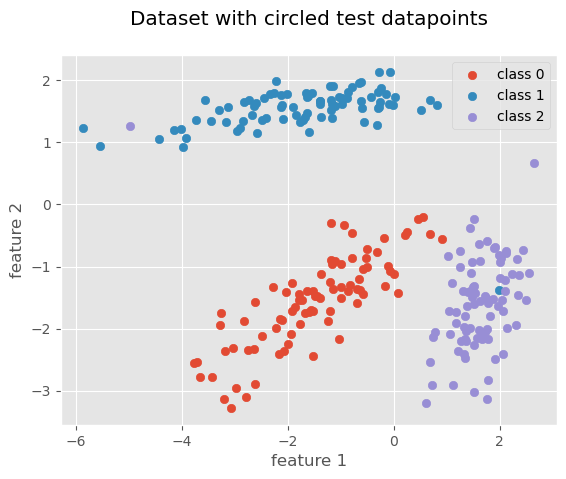

In [13]:
N_classes = 3

data = make_classification(n_samples=250, n_features=2, n_classes=N_classes, n_redundant=0, n_informative=2, 
                           hypercube=True, n_clusters_per_class=1, class_sep=1.6, random_state=5)

Xs = data[0]
ys = data[1]

for i in range(N_classes):
    class_i = Xs[ys == i]
    plt.scatter(class_i[:, 0], class_i[:, 1], label=f'class {i}')

plt.title('Dataset with circled test datapoints\n')
plt.legend()
plt.xlabel('feature 1')
plt.ylabel('feature 2')

### 2.1.2 Independent neural network for artificial dataset

#### 2.1.2.1 Defining the network architecture

Define a network with two hidden layers and Tanh activation function.

In [14]:
network = [
    Dense_Layer(2, 10),
    activation_layer(tanh, tanh_prime),
    Dense_Layer(10, 10),
    activation_layer(tanh, tanh_prime),
    Dense_Layer(10, 3),
]

#### 2.1.2.2 Train the defiend network

Train the defined model on created dataset and evaluate the accuracy on both train and test sets.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=3)

train(X_train, 
      y_train, 
      X_test, 
      y_test, 
      network, 
      cross_entropy, 
      cross_entropy_prime, 
      learning_rate=3, 
      reg_func=apply_L2_regularization, 
      reg_func_prime=apply_L2_regularization_prime,
      reg_rate=0, 
      epochs=400,
      verbose=25)

epoch    0/400 | accuracy on train: 0.350 | accuracy on test: 0.280 | loss: 219.731 | sum of weights: 0.1654
epoch   25/400 | accuracy on train: 0.960 | accuracy on test: 1.000 | loss: 77.953 | sum of weights: 3.1835
epoch   50/400 | accuracy on train: 0.985 | accuracy on test: 1.000 | loss: 27.971 | sum of weights: 5.7580
epoch   75/400 | accuracy on train: 0.990 | accuracy on test: 1.000 | loss: 15.914 | sum of weights: 6.2611
epoch  100/400 | accuracy on train: 0.990 | accuracy on test: 1.000 | loss: 13.096 | sum of weights: 6.5026
epoch  125/400 | accuracy on train: 0.990 | accuracy on test: 1.000 | loss: 11.857 | sum of weights: 6.8022
epoch  150/400 | accuracy on train: 0.990 | accuracy on test: 1.000 | loss: 11.403 | sum of weights: 7.0682
epoch  175/400 | accuracy on train: 0.990 | accuracy on test: 1.000 | loss: 11.148 | sum of weights: 7.2842
epoch  200/400 | accuracy on train: 0.990 | accuracy on test: 1.000 | loss: 10.982 | sum of weights: 7.4644
epoch  225/400 | accuracy o

#### 2.1.2.3 Plot decision boundaries for trained model

In [16]:
output = X_train.T
for layer in network:
    output = layer.forward(output)

    
train_predicts = predict(X_train, network)

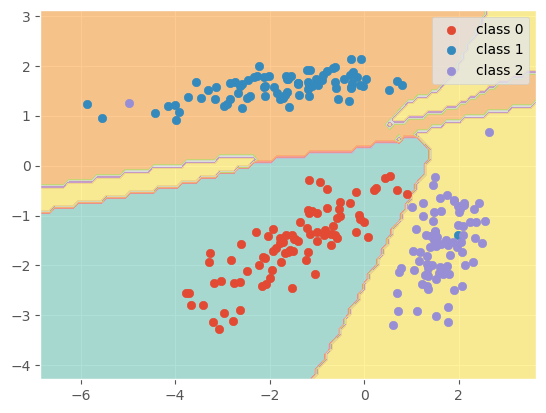

In [17]:
decision_surface(network, predict, plt, Xs, ys, 3)

### 2.1.3 PyTorch for artificial dataset

#### 2.1.3.1 Defining the network architecture

Define a network with same architecture as above network, but using PyTorch

In [18]:
class ArtificialData(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Tanh(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Tanh(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

        
    def forward(self, x):
        return self.layer_stack(x)

Using the same architecture and optimization technique as above experiment.

In [19]:
clf_model = ArtificialData(2, 10, 3)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=clf_model.parameters(), lr=3)

clf_model

ArtificialData(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

#### 2.1.3.2 Train and evaluatethe defined model

In [20]:
epochs = 400

train_loss, train_acc = [], []
test_loss, test_acc = [], []

X_train_t, X_test_t, y_train_t, y_test_t = torch.tensor(X_train).type(torch.float), torch.tensor(X_test).type(torch.float), torch.tensor(y_train).type(torch.LongTensor), torch.tensor(y_test).type(torch.LongTensor) 

# add a loop to loop through the training batches
for epoch in range(epochs):
    # put model into training mode 
    clf_model.train()

    # 1. forward pass (outputs the raw logits from the model)
    train_scores = clf_model(X_train_t)
    train_preds = train_scores.detach().numpy().argmax(axis=1) # go from logits -> prediction labels
    
    # 2. calcualate loss and accuracy (per batch)
    loss = loss_fn(train_scores, y_train_t)
    train_loss.append(loss)    # accumlate train loss 
    acc = np.mean(y_train == train_preds)
    train_acc.append(acc)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    if epoch % 50 == 0:
        
        print(f"{epoch:4}/{epochs} | Train loss: {loss:.4f} | Train accuracy: {acc:.2f}%")  
          
        # put the model in eval mode
        clf_model.eval()

        # turn on indference mode context manager
        with torch.inference_mode():
            # 1. forward pass (outputs raw logits)
            test_scores = clf_model(X_test_t)
            test_preds = test_scores.numpy().argmax(axis=1) # go from logits -> prediction labels
            

            # 2. calculate the loss and accuracy
            loss = loss_fn(test_scores, y_test_t)
            test_loss.append(loss)

            acc = np.mean(y_test == test_preds)
            test_acc.append(acc)

            print(f"{epoch:4}/{epochs} | Test loss: {loss:.4f}  | Test accuracy: {acc:.2f}%\n")  

   0/400 | Train loss: 1.0920 | Train accuracy: 0.20%
   0/400 | Test loss: 0.6332  | Test accuracy: 0.66%

  50/400 | Train loss: 0.0600 | Train accuracy: 0.99%
  50/400 | Test loss: 0.0211  | Test accuracy: 1.00%

 100/400 | Train loss: 0.0536 | Train accuracy: 0.99%
 100/400 | Test loss: 0.0150  | Test accuracy: 1.00%

 150/400 | Train loss: 0.0514 | Train accuracy: 0.99%
 150/400 | Test loss: 0.0154  | Test accuracy: 1.00%

 200/400 | Train loss: 0.0491 | Train accuracy: 0.99%
 200/400 | Test loss: 0.0178  | Test accuracy: 1.00%

 250/400 | Train loss: 0.0441 | Train accuracy: 0.99%
 250/400 | Test loss: 0.0194  | Test accuracy: 1.00%

 300/400 | Train loss: 0.0402 | Train accuracy: 0.99%
 300/400 | Test loss: 0.0212  | Test accuracy: 1.00%

 350/400 | Train loss: 0.0386 | Train accuracy: 0.99%
 350/400 | Test loss: 0.0225  | Test accuracy: 1.00%



#### 2.1.3.3 Plot decision boundaries for trained model

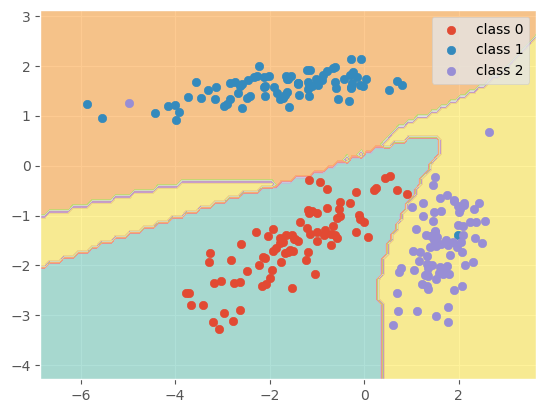

In [21]:
decision_surface_torch(clf_model, plt, Xs, ys, 3)

---

## 2.2 Models on MNIST

### 2.2.1 Loading MNIST dataset using PyTorch

In this experiment we use PyTorch to load MNIST dataset for both independent and PyTorch classifiers.

In [22]:
# setup training and testing data
DATA_PATH = 'D:\PyTorch_datasets'

mnist_train_data = datasets.MNIST(
    root=DATA_PATH,
    train=True,
    download=True,
    transform=ToTensor(),    # how do we want to transform the data
    target_transform=None    # how do we want to transform the labels/targets
)

mnist_test_data = datasets.MNIST(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [23]:
mnist_train_data.data.shape, mnist_train_data.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

### 2.2.2 Independent neural network on MNIST dataset

#### 2.2.2.1 make the data ready for Independent model

The data now we have is in tensor form, we want the data in the form of numpy arrays for our independent model, so the next
cell is dedicated to transform the data type, as well as its shape, to flatten the 28 * 28 MNIST images. 

In [24]:
# transform data type and shape for training data
X_train_mn = mnist_train_data.data.numpy().reshape(mnist_train_data.data.shape[0], mnist_train_data.data.shape[1] * mnist_train_data.data.shape[2])
y_train_mn = mnist_train_data.targets.numpy()

# transform data type and shape for testing data
X_test_mn = mnist_test_data.data.numpy().reshape(mnist_test_data.data.shape[0], mnist_test_data.data.shape[1] * mnist_test_data.data.shape[2])
y_test_mn = mnist_test_data.targets.numpy()

X_train_mn.shape, y_train_mn.shape, X_test_mn.shape, y_test_mn.shape

((60000, 784), (60000,), (10000, 784), (10000,))

#### 2.2.2.2 Define the architecture for network

Define a network architecture with three hidden layers and **Leaky ReLU** activation function.

In [25]:
mnist_network = [
    Dense_Layer(784, 100),
    activation_layer(leaky_relu, leaky_relu_prime),
    Dense_Layer(100, 100),
    activation_layer(leaky_relu, leaky_relu_prime),
    Dense_Layer(100, 100),
    activation_layer(leaky_relu, leaky_relu_prime),
    Dense_Layer(100, 10)   
]

#### 2.2.2.3 Train the defined network

Train and evaluate the defined independent model on the MNIST dataset. In this experiment we are using stochastic gradient descent (also known as batch gradient descent), with a batch-size of 1024.

In [26]:
train(X_train_mn, 
      y_train_mn, 
      X_test_mn, 
      y_test_mn, 
      mnist_network, 
      multi_class_hinge, 
      multi_class_hinge_prime, 
      learning_rate=2, 
      reg_func=apply_L2_regularization, 
      reg_func_prime=apply_L2_regularization_prime, 
      reg_rate=0.0, 
      epochs=2000,
      sgd=True,
      batch_size=1024,
      verbose=100)

epoch    0/2000 | accuracy on train: 0.096 | accuracy on test: 0.100 | loss: 8.995 | sum of weights: -0.4373
epoch  100/2000 | accuracy on train: 0.490 | accuracy on test: 0.479 | loss: 8.956 | sum of weights: -1.7608
epoch  200/2000 | accuracy on train: 0.581 | accuracy on test: 0.583 | loss: 8.953 | sum of weights: -2.1892
epoch  300/2000 | accuracy on train: 0.632 | accuracy on test: 0.630 | loss: 8.952 | sum of weights: -2.4648
epoch  400/2000 | accuracy on train: 0.656 | accuracy on test: 0.663 | loss: 8.951 | sum of weights: -2.6758
epoch  500/2000 | accuracy on train: 0.650 | accuracy on test: 0.680 | loss: 8.954 | sum of weights: -2.8600
epoch  600/2000 | accuracy on train: 0.687 | accuracy on test: 0.696 | loss: 8.953 | sum of weights: -3.0172
epoch  700/2000 | accuracy on train: 0.713 | accuracy on test: 0.707 | loss: 8.953 | sum of weights: -3.1532
epoch  800/2000 | accuracy on train: 0.689 | accuracy on test: 0.718 | loss: 8.955 | sum of weights: -3.2806
epoch  900/2000 | a

After training the model, predict the label for 16 random samples from test set and plot the output. 

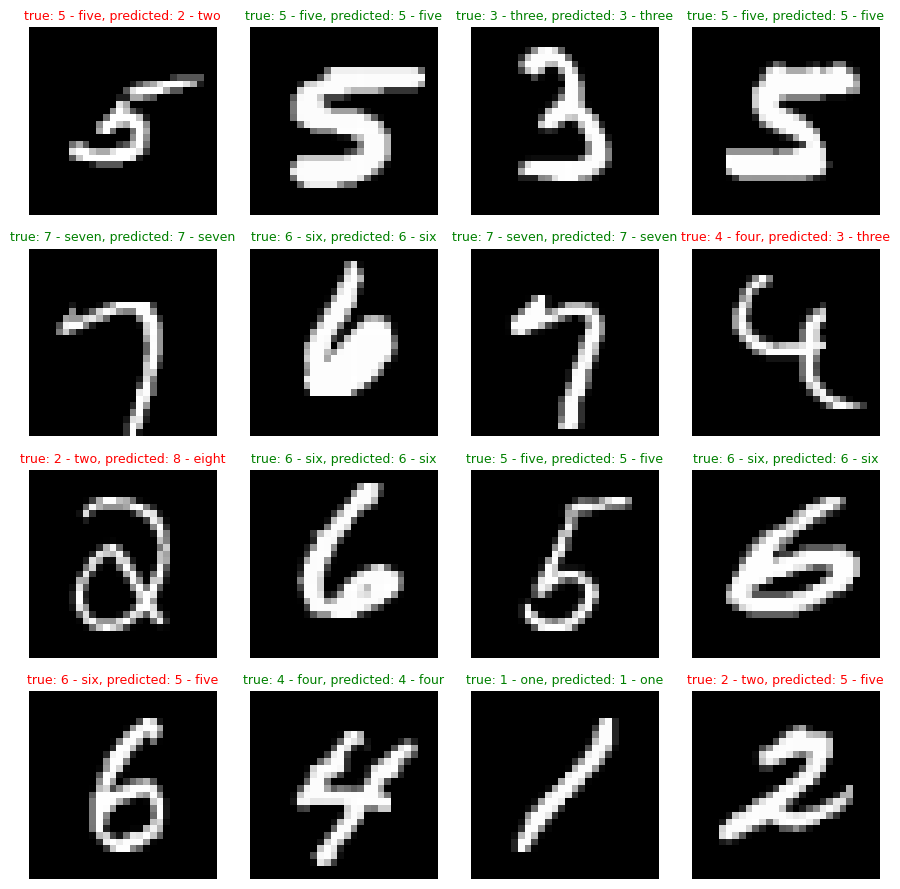

In [27]:
torch.manual_seed(42)

number_of_images = 16
ncols = 4
nrows = 4

# pick some random images from the train set
random_idx = torch.randint(low=0, high=len(mnist_test_data), size=(number_of_images,))#.item()
images = mnist_test_data.data[random_idx].type(torch.float32).numpy().reshape(16, -1)
labels = mnist_test_data.targets[random_idx].numpy()

scores = images.T
for layer in mnist_network:
    scores = layer.forward(scores)
    

preds = predict(images, mnist_network)


# plot the images and the predicted label for each one alongside it's real label
plt.figure(figsize=(9, 9))
for i, img in enumerate(images):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img.reshape(28, 28), cmap='gray')#.permute(2, 1, 0))
    
    if labels[i] == preds[i]:
        plt.title(f'true: {mnist_test_data.classes[labels[i]]}, predicted: {mnist_test_data.classes[preds[i]]}', fontsize=9, c='g')
    else:
        plt.title(f'true: {mnist_test_data.classes[labels[i]]}, predicted: {mnist_test_data.classes[preds[i]]}', fontsize=9, c='r')
    plt.grid('off')
    plt.axis('off')

plt.tight_layout()


### 2.2.3 PyTorch on MNIST implementation

#### 2.2.3.1 Make the data ready for PyTorch model

To perform stochastic gradient descent as optimization technique in PyTorch model, we need to turn our train and test datasets into dataloaders. 

In [28]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader

# The chosen batch size for this experiment is 1024 samples
BATCH_SIZE = 1024
mnist_train_dataloader = DataLoader(dataset=mnist_train_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
mnist_test_dataloader = DataLoader(dataset=mnist_test_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

mnist_train_dataloader, mnist_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2a699281430>,
 <torch.utils.data.dataloader.DataLoader at 0x2a699281460>)

#### 2.2.3.2 Define and the network architecture

Define a network with same architecture as above network, but using PyTorch. We're using a flatten layer as first layer, which provides us ability to input data with it's original shape, needless to reshape it.

In [29]:
class MNISTClassifier(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

Using the same loss function and optimization technique as above experiment.

In [30]:
mnist_model = MNISTClassifier(input_shape=784, hidden_units=100, output_shape=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=mnist_model.parameters(), lr=0.1)

mnist_model

MNISTClassifier(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

#### 2.2.3.3 Train and evaluate the defined network

Train and evaluate the created model usnig PyTroch on train and test sets.

In [31]:
torch.manual_seed(42)

# set epochs
epochs = 10

# create an optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(model=mnist_model, 
               data_loader=mnist_train_dataloader, 
               loss_fn=loss_fn, 
               optimizer=optimizer, 
               accuracy_fn=accuracy_fn,
               device='cpu')
    
    test_step(model=mnist_model,
              data_loader=mnist_test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device='cpu')
    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
batch (128 samples):    0/59 | Train loss: 2.30710 | Train accuracy: 7.52%
batch (128 samples):   25/59 | Train loss: 2.18498 | Train accuracy: 40.14%
batch (128 samples):   50/59 | Train loss: 1.74717 | Train accuracy: 64.16%
End of an epoch --> Train loss: 2.05800 | Train accuracy: 44.25%

-------
Test loss: 1.45951 | Test accuracy: 71.28%
-------

Epoch: 1
-------
batch (128 samples):    0/59 | Train loss: 1.49995 | Train accuracy: 69.14%
batch (128 samples):   25/59 | Train loss: 0.90745 | Train accuracy: 79.20%
batch (128 samples):   50/59 | Train loss: 0.67510 | Train accuracy: 82.03%
End of an epoch --> Train loss: 0.92947 | Train accuracy: 77.56%

-------
Test loss: 0.61681 | Test accuracy: 83.51%
-------

Epoch: 2
-------
batch (128 samples):    0/59 | Train loss: 0.64384 | Train accuracy: 82.23%
batch (128 samples):   25/59 | Train loss: 0.57122 | Train accuracy: 84.86%
batch (128 samples):   50/59 | Train loss: 0.46677 | Train accuracy: 88.18%
End of an epoc

After training the model, predict the label for 16 random samples from test set and plot the output.

*Note: The purpose of this experiment is not comparing the results of the independent and PyTorch-based models (as the learning procedure is a little bit different, in other words, the circumstance for two models is not exactly the same).*

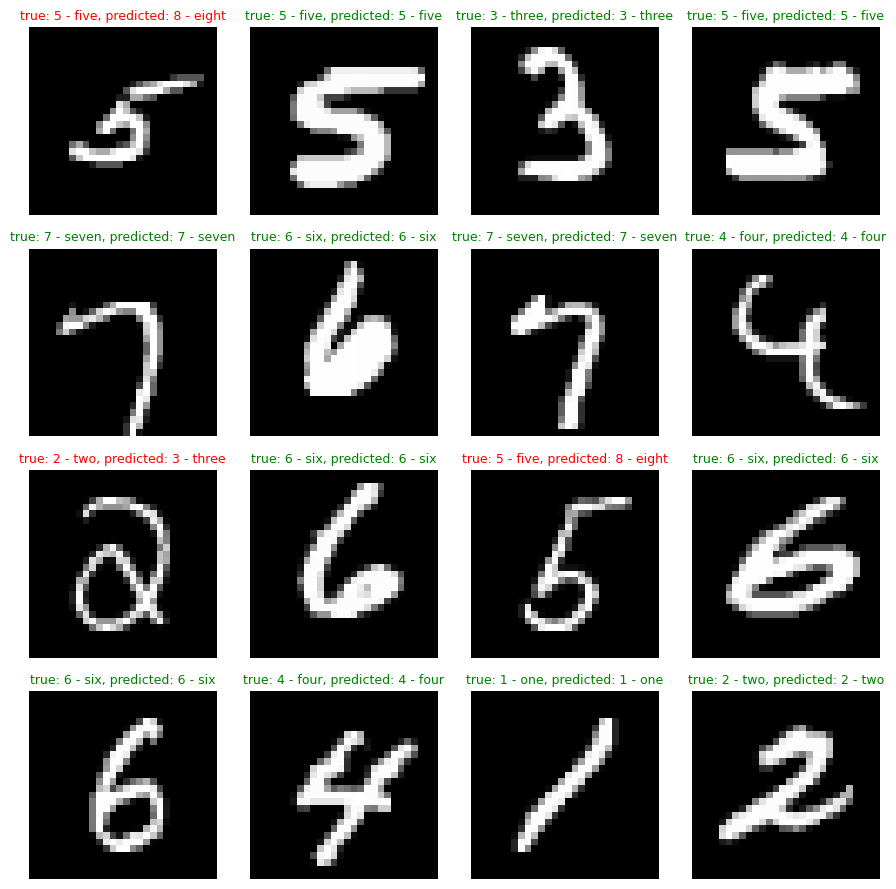

In [32]:
torch.manual_seed(42)

number_of_images = 16
ncols = 4
nrows = 4

# pick some random images from the train set
random_idx = torch.randint(low=0, high=len(mnist_test_data), size=(number_of_images,))#.item()
images = mnist_test_data.data[random_idx].type(torch.float32)
labels = mnist_test_data.targets[random_idx]

mnist_model.eval()
with torch.inference_mode():
    scores = mnist_model(images)

preds = torch.softmax(scores, dim=1).argmax(dim=1)


# plot the images and the predicted label for each one alongside it's real label
plt.figure(figsize=(9, 9))
for i, img in enumerate(images):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img.type(torch.int), cmap='gray')#.permute(2, 1, 0))
    
    if labels[i] == preds[i]:
        plt.title(f'true: {mnist_test_data.classes[labels[i]]}, predicted: {mnist_test_data.classes[preds[i]]}', fontsize=9, c='g')
    else:
        plt.title(f'true: {mnist_test_data.classes[labels[i]]}, predicted: {mnist_test_data.classes[preds[i]]}', fontsize=9, c='r')
    plt.grid('off')
    plt.axis('off')

plt.tight_layout()

## 2.4 Models on CIFAR-10

### 2.4.1 Loading CIFAR-10 dataset using PyTorch

In this experiment we use PyTorch to load CIFAR-10 dataset for both independent and PyTorch classifiers.

### 2.4.2 Independent neural network on CIFAR-10 dataset

#### 2.4.2.1 Load the data for the independent model using PyTorch

In [33]:
# setup training data

DATA_PATH = 'D:\PyTorch_datasets'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

cifar10_train_data = datasets.CIFAR10(
    root=DATA_PATH,
    train=True,
    download=True,
    transform=ToTensor(),    # how do we want to transform the data
    target_transform=None    # how do we want to transform the labels/targets
)

cifar10_test_data = datasets.CIFAR10(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
# transform data type and shape for training data
cifar10_X_train = cifar10_train_data.data.reshape(cifar10_train_data.data.shape[0], -1).astype(np.float32)
cifar10_y_train = np.array(cifar10_train_data.targets)

# transform data type and shape for testing data
cifar10_X_test = cifar10_test_data.data.reshape(cifar10_test_data.data.shape[0], -1).astype(np.float32)
cifar10_y_test = np.array(cifar10_test_data.targets)

cifar10_X_train.shape, cifar10_y_train.shape, cifar10_X_test.shape, cifar10_y_test.shape

((50000, 3072), (50000,), (10000, 3072), (10000,))

In [35]:
class_names = cifar10_train_data.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Subtract the mean of all training images from both train and test sets, in order to make the mean of train images equal to zero.

In [36]:
mean_of_images = np.mean(cifar10_X_train, axis=0)

cifar10_X_train -= mean_of_images
cifar10_X_test -= mean_of_images

#### 2.4.2.2 Define the architecture of network

Define a network architecture with three hidden layers and **Leaky ReLU** activation function.

In [37]:
c10_network = [
    Dense_Layer(3072, 4000),
    activation_layer(leaky_relu, leaky_relu_prime),
    Dense_Layer(4000, 1000),
    activation_layer(leaky_relu, leaky_relu_prime),
    Dense_Layer(1000, 4000),
    activation_layer(leaky_relu, leaky_relu_prime),
    Dense_Layer(4000, 10),
]

#### 2.4.2.3 Train and evaluate the defined network

Train and evaluate the defined independent model on the CIFAR-10 dataset. In this experiment we are using stochastic gradient descent (also known as batch gradient descent), with a batch-size of 256.

In [38]:
train(  cifar10_X_train, 
        cifar10_y_train, 
        cifar10_X_test, 
        cifar10_y_test,  
        c10_network, 
        multi_class_hinge, 
        multi_class_hinge_prime, 
        learning_rate=1e-1, 
        reg_func=apply_L2_regularization, 
        reg_func_prime=apply_L2_regularization_prime, 
        reg_rate=1e-9, 
        epochs=960,
        sgd=True,
        batch_size=256,
        verbose=30)

epoch    0/960 | accuracy on train: 0.219 | accuracy on test: 0.156 | loss: 11.101 | sum of weights: 25.7662
epoch   30/960 | accuracy on train: 0.348 | accuracy on test: 0.301 | loss: 5.336 | sum of weights: -200.8723
epoch   60/960 | accuracy on train: 0.395 | accuracy on test: 0.293 | loss: 5.296 | sum of weights: -273.0326
epoch   90/960 | accuracy on train: 0.379 | accuracy on test: 0.308 | loss: 4.753 | sum of weights: -329.0390
epoch  120/960 | accuracy on train: 0.461 | accuracy on test: 0.325 | loss: 4.524 | sum of weights: -365.3507
epoch  150/960 | accuracy on train: 0.426 | accuracy on test: 0.334 | loss: 4.095 | sum of weights: -396.9270
epoch  180/960 | accuracy on train: 0.477 | accuracy on test: 0.363 | loss: 4.785 | sum of weights: -422.1888
epoch  210/960 | accuracy on train: 0.422 | accuracy on test: 0.342 | loss: 5.005 | sum of weights: -443.2658
epoch  240/960 | accuracy on train: 0.484 | accuracy on test: 0.355 | loss: 4.706 | sum of weights: -462.7728
epoch  270/

After training the model, predict the label for 16 random samples from test set and plot the output.

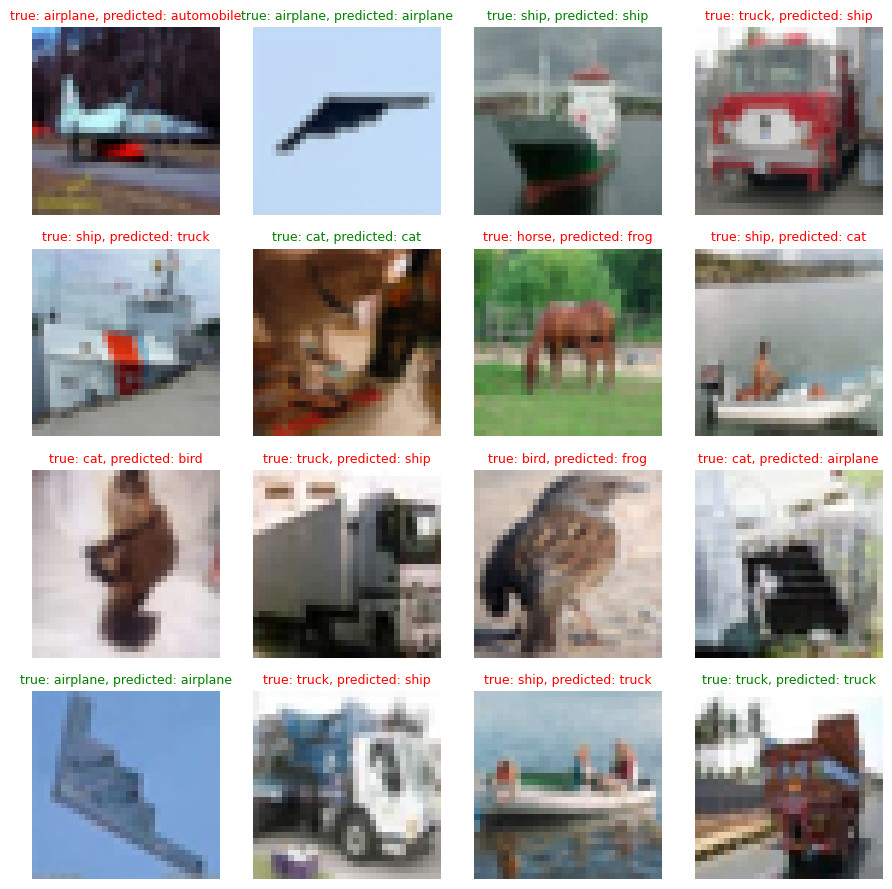

In [39]:
np.random.seed(12)

number_of_images = 16
ncols = 4
nrows = 4


# pick some random images from the train set
random_indices = np.random.choice(np.arange(0, len(cifar10_test_data.data)), number_of_images, replace=False)
random_images = cifar10_test_data.data[random_indices]
random_labels = np.array(cifar10_test_data.targets)[random_indices]

random_images = random_images.reshape(random_images.shape[0], -1).astype(np.float32)
random_images -= mean_of_images

# do the forward pass and output the computed scores for each class
output = random_images.T
for layer in c10_network:
    output = layer.forward(output)

    
# convert the scores to class labels    
predicts = predict(random_images, c10_network)
accuracy_on_train = np.mean(predicts == random_labels)


# add the mean of images back
random_images += mean_of_images


# plot the images and the predicted label for each one alongside it's real label
plt.figure(figsize=(9, 9))
for i in range(number_of_images):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(random_images[i, :].reshape(32, 32, 3).astype('int'))
    
    if random_labels[i] == predicts[i]:
        plt.title(f'true: {class_names[random_labels[i]]}, predicted: {class_names[predicts[i]]}', fontsize=9, c='g')
    else:
        plt.title(f'true: {class_names[random_labels[i]]}, predicted: {class_names[predicts[i]]}', fontsize=9, c='r')
    plt.grid('off')
    plt.axis('off')

plt.tight_layout()

### 2.4.3 PyTorch on Cifar-10 dataset

#### 2.4.3.1 Make the data ready for PyTorch model

To perform stochastic gradient descent as optimization technique in PyTorch model, we need to turn our train and test datasets into dataloaders.

In [40]:
# setup the batch size hyperparameter
BATCH_SIZE = 256

# turn dataset into iterables (batches)
cifar10_train_dataloader = DataLoader(dataset=cifar10_train_data, batch_size=BATCH_SIZE, shuffle=True)

cifar10_test_dataloader = DataLoader(dataset=cifar10_test_data, batch_size=1000, shuffle=False)

cifar10_train_dataloader, cifar10_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2a69b47daf0>,
 <torch.utils.data.dataloader.DataLoader at 0x2a6a3373b80>)

In [41]:
# check out what's inside the training dataloader
train_features_batch, train_label_batch = next(iter(cifar10_train_dataloader))

train_features_batch.shape, train_label_batch.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

#### 2.4.3.2 Define the architecture of network

Replicate the architecture of above netwrok using PyTorch.

In [42]:
class Cifar10ModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=4000),
            nn.LeakyReLU(),
            nn.Linear(in_features=4000, out_features=1000),
            nn.LeakyReLU(),
            nn.Linear(in_features=1000, out_features=4000),
            nn.LeakyReLU(),
            nn.Linear(in_features=4000, out_features=output_shape)
        )

        
    def forward(self, x):
        return self.layer_stack(x)

Using the same loss function and optimization technique as above experiment.

In [43]:
torch.manual_seed(42)

cifar10_model = Cifar10ModelV0(input_shape=3072, hidden_units=0, output_shape=len(class_names)).to('cpu')

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cifar10_model.parameters(), lr=0.01)

cifar10_model

Cifar10ModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=4000, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=4000, out_features=1000, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=1000, out_features=4000, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=4000, out_features=10, bias=True)
  )
)

#### 2.4.3.3 Train the defined model

Train and evaluate the created PyTorch model on train and test sets.

In [44]:
torch.manual_seed(42)

# set epochs
epochs = 10

# create an optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(model=cifar10_model, 
               data_loader=cifar10_train_dataloader, 
               loss_fn=loss_fn, 
               optimizer=optimizer, 
               accuracy_fn=accuracy_fn,
               device='cpu')
    
    test_step(model=cifar10_model,
              data_loader=cifar10_test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
batch (128 samples):    0/196 | Train loss: 2.30458 | Train accuracy: 7.42%
batch (128 samples):   25/196 | Train loss: 2.29761 | Train accuracy: 17.19%
batch (128 samples):   50/196 | Train loss: 2.29417 | Train accuracy: 6.64%
batch (128 samples):   75/196 | Train loss: 2.28826 | Train accuracy: 14.06%
batch (128 samples):  100/196 | Train loss: 2.27544 | Train accuracy: 16.02%
batch (128 samples):  125/196 | Train loss: 2.26784 | Train accuracy: 12.50%
batch (128 samples):  150/196 | Train loss: 2.26570 | Train accuracy: 17.19%
batch (128 samples):  175/196 | Train loss: 2.26404 | Train accuracy: 19.14%
End of an epoch --> Train loss: 2.28262 | Train accuracy: 13.40%

-------
Test loss: 2.25680 | Test accuracy: 15.71%
-------

Epoch: 1
-------
batch (128 samples):    0/196 | Train loss: 2.25877 | Train accuracy: 15.62%
batch (128 samples):   25/196 | Train loss: 2.24508 | Train accuracy: 19.53%
batch (128 samples):   50/196 | Train loss: 2.25416 | Train accuracy: 17

In [45]:
test_step(model=cifar10_model,
              data_loader=cifar10_test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device='cpu')

-------
Test loss: 1.77815 | Test accuracy: 36.78%
-------



After training the model, predict the label for 16 random samples (same as above experiment) from test set and plot the output.

*Note: The purpose of this experiment is not comparing the results of the independent and PyTorch-based models (as the learning procedure is a little bit different, in other words, the circumstance for two models isn't exactly the same).*

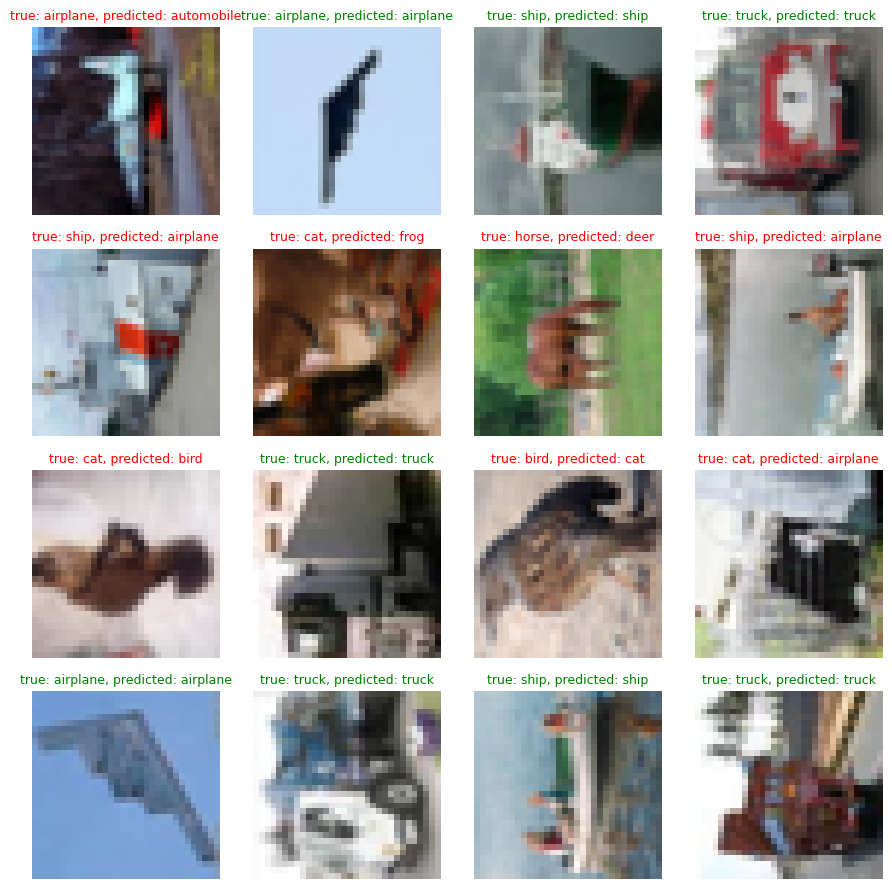

In [46]:
np.random.seed(12)

number_of_images = 16
ncols = 4
nrows = 4

# pick some random images from the train set
random_idx = torch.tensor(np.random.choice(np.arange(0, len(cifar10_test_data.data)), number_of_images, replace=False))
images = torch.tensor(cifar10_test_data.data[random_idx]).type(torch.float32).permute(0, 3, 1, 2)
labels = torch.tensor(cifar10_test_data.targets)[random_idx]

cifar10_model.eval()
with torch.inference_mode():
    scores = cifar10_model(images)
preds = torch.softmax(scores, dim=1).argmax(dim=1)


# plot the images and the predicted label for each one alongside it's real label
plt.figure(figsize=(9, 9))
for i, img in enumerate(images):
    plt.subplot(nrows, ncols, i+1)
#     print(img.type())
    plt.imshow(img.type(torch.int).permute(2, 1, 0))
    
    if labels[i] == preds[i]:
        plt.title(f'true: {class_names[labels[i]]}, predicted: {class_names[preds[i]]}', fontsize=9, c='g')
    else:
        plt.title(f'true: {class_names[labels[i]]}, predicted: {class_names[preds[i]]}', fontsize=9, c='r')
    plt.grid('off')
    plt.axis('off')

plt.tight_layout()